---

# Drone Image Analysis with GeoStats.jl

This notebook presents a complete workflow for analyzing drone imagery in agricultural experiments, demonstrating how to leverage the **GeoStats.jl** ecosystem in Julia. Inspired by the functionalities of **FIELDimageR** (R), we start from an **orthomosaic** (generated via *OpenDroneMap™*) and use the GeoStats.jl tools to:

* load and organize geospatial data;
* calculate **vegetation indices**;
* delineate **plots** and extract metrics per plot;
* **summarize** and visualize the results.

The goal is to showcase how GeoStats.jl provides an **integrated, high-performance framework** for geospatial data science, allowing not only the replication of traditional agronomic analyses but also the ability to **extend** them with advanced **geostatistics** techniques.

In [1]:
begin 
    using Pkg;
    Pkg.add(["GeoStats", "GeoIO", "Tyler", "GeometryBasics", "Downloads", "CairoMakie", "CSV", "DataFrames"]);
    
    # --- Core Geospatial Framework ---
    # The main package of the GeoStats.jl ecosystem, providing the core types and methods for geostatistical problems.
    using GeoStats
    
    # --- Input/Output Modules ---
    # Provides functions to load and save a variety of geospatial file formats (e.g., Shapefile, GeoPackage, GeoTIFF).
    using GeoIO
	# Standard library for downloading files from URLs (e.g., via HTTP/HTTPS).
    using Downloads
    
    # --- Visualization & Geometry Modules ---
    # Imports the Makie backend for creating interactive, web-based plots (e.g., in Pluto or Jupyter). t's aliased as `Mke`.
    import CairoMakie as Mke

    # Provides tools to fetch and display map tiles from providers like OpenStreetMap as a plot background.
    using Tyler
    using Tyler.TileProviders
    using Tyler.MapTiles
	
    # Provides fundamental geometric types (e.g., Point, Rect) used by the Makie plotting ecosystem.
    using GeometryBasics: Rect2f
    
    # --- Tabular Data Handling ---
    # A fast and flexible package for reading and writing comma-separated value (CSV) files.
    using CSV
    # Provides the `DataFrame` type, a powerful and feature-rich tool for working with tabular data in memory, similar to R's data.frame or pandas' DataFrame.
    using DataFrames
end

   Resolving package versions...
     Project No packages added to or removed from `C:\Users\marco\.julia\environments\v1.12\Project.toml`
    Manifest No packages added to or removed from `C:\Users\marco\.julia\environments\v1.12\Manifest.toml`


In [2]:
begin
	# Define the direct RAW URLs for the files on GitHub
	url_tif = "https://raw.githubusercontent.com/marcosdanieldasilva/AgricultureTutorials/main/data/rgb_ex1.tif"
	url_csv = "https://raw.githubusercontent.com/marcosdanieldasilva/AgricultureTutorials/main/data/data_ex1.csv"
	
	# Define the local names for the files
	nome_tif = "rgb_ex1.tif"
	nome_csv = "data_ex1.csv"

	# Download and load the image into the `img` variable
	println("Downloading TIF image from GitHub...")
	Downloads.download(url_tif, nome_tif)
	# Load, Select and rename the first three bands to R, G, and B.
	img = GeoIO.load(nome_tif) |> Select(1=> "R", 2 => "G", 3 => "B")
	println("Image successfully loaded into the 'img' variable.")

	# Download and load the table into the `data` variable
	println("\nDownloading CSV table from GitHub...")
	Downloads.download(url_csv, nome_csv)
	data = CSV.read(nome_csv, DataFrame)
	println("Table successfully loaded into the 'data' variable.")

	# Show the first few rows of the table to confirm
	println("\nPreview of the 'data' table:")
	display(first(data, 5))
end

Image successfully loaded into the 'img' variable.

Table successfully loaded into the 'data' variable.

Preview of the 'data' table:


5×9 DataFrame
 Row │ Plot   Block  Row    Range  Weight   Height   Maturity  Yield    TuberS ⋯
     │ Int64  Int64  Int64  Int64  Float64  Float64  Int64     Float64  Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      1      1      1     4.25     21.0         4  445.884   9.733 ⋯
   2 │     2      1      2      1     5.33     14.5         5  475.991   9.133
   3 │     3      1      3      1     3.76     37.5         5  468.163  12.2
   4 │     4      1      4      1     3.99     12.5         4  341.132   8.733
   5 │     5      1      5      1     6.79     25.5         3  532.006   8.2   ⋯
                                                                1 column omitted

In [3]:
# Print a summary of the GeoTable's columns, including their data types and other properties.
describe(img)

Table with 6 columns and 3 rows:
     variable  mean     minimum  median   maximum  nmissing
   ┌───────────────────────────────────────────────────────
 1 │ R         104.976  7.0625   119.293  232.918  0
 2 │ G         92.8246  7.17188  99.9219  172.988  0
 3 │ B         68.4456  5.28516  77.3477  160.117  0

In [4]:
"""
    ColorView(; color=RGB, low=0.02, high=0.98, cname="RGB")

Creates a reusable GeoStats.jl transform for color visualization.

This function is necessary because raw sensor data (e.g., from a drone or satellite)
often has a wide dynamic range (e.g., 12-bit or 16-bit integers) that cannot be displayed
directly on a screen. This transform replicates the common "contrast stretch"
seen in GIS software like QGIS.

It first performs a percentile stretch using `LowHigh` and then converts the
normalized R, G, B channels into a single color column.

# Parameters
- `color`: The function to use for creating a color object. Defaults to `RGB`.
- `low`: The lower percentile for the contrast stretch. Defaults to `0.02` (2nd percentile).
- `high`: The upper percentile for the contrast stretch. Defaults to `0.98` (98th percentile).
- `cname`: The name of the final output color column. Defaults to `"RGB"`.

Setting `low=0.0` and `high=1.0` will perform a full stretch between the absolute
minimum and maximum values of the data.
"""
ColorView(; color=RGB, low=0.02, high=0.98, cname="RGB") = 
    LowHigh(; low, high) → Map(color => cname)

ColorView

In [5]:
processed_image = img |> ColorView()

                645381×2 GeoTable over 477×1353 TransformedGrid
┌────────────────────────────────────────────┬──────────────────────────────────
│                    RGB                     │                                 ⋯
│                  Colorful                  │                                 ⋯
│                 [NoUnits]                  │                          🖈 Tran ⋯
├────────────────────────────────────────────┼──────────────────────────────────
│ RGB{Float32}(0.397955, 0.530405, 0.32832)  │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.429518, 0.573925, 0.372275) │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.424916, 0.544468, 0.335725) │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.405682, 0.502526, 0.26189)  │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.434498, 0.558481, 0.329581) │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.405614, 0.52029, 0.284313)  │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.399947, 0.505734, 0.274703) │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.44068, 0.567165, 0.327218)  │  Quadrangle((x: 296601.0 m, y:  ⋯
│ RGB{Float32}(0.400943, 0.518661, 0.266301) │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│ RGB{Float32}(0.356638, 0.497641, 0.239203) │ Quadrangle((x: 2.96601e5 m, y:  ⋯
│                     ⋮                      │                                 ⋱
└────────────────────────────────────────────┴──────────────────────────────────
                                                1 column and 645371 rows omitted

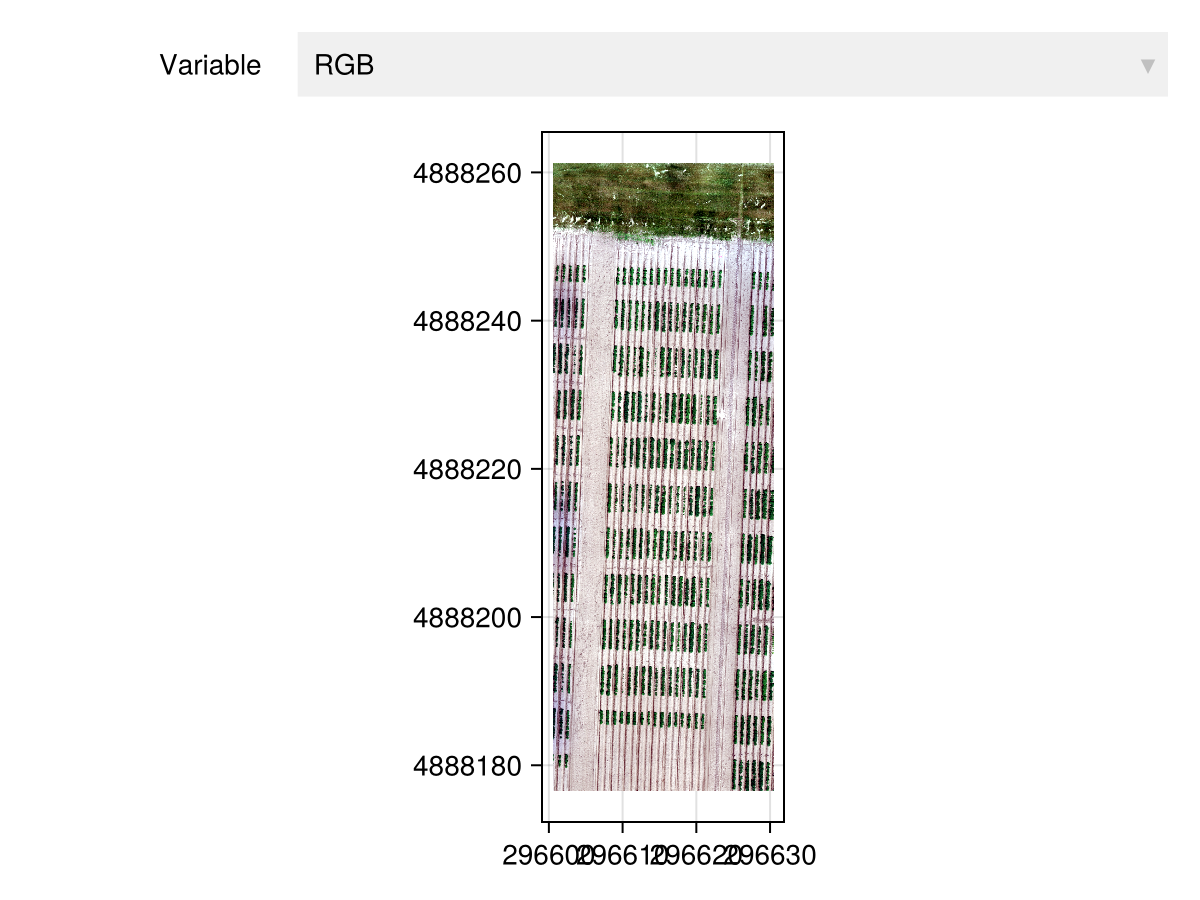

In [6]:
processed_image |> viewer

In [ ]:
# NOTE: if you change CairoMakie to GLMakie you can visualize Basemaps like Google via Tyler using this script:
# Define `extented_box` to enlarge the extent of a Meshes.jl `Box`.
function extented_box(box::Box)

    # Get min and max corner coordinates.
    cmin, cmax = coords.(extrema(box))

    # Extract latitude/longitude (assumes geographic coords).
    lat1, lon1 = (cmin.lat, cmin.lon) .|> ustrip
    lat2, lon2 = (cmax.lat, cmax.lon) .|> ustrip

    # Compute width (lon) and height (lat).
    δlon = abs(lon1 - lon2)
    δlat = abs(lat1 - lat2)

    # Build a larger rectangular extent.
    extent = Rect2f(lon1 - δlon/2, lat1 - δlat/2, 2δlon, 2δlat)

    return extent
end

# Get bounding box in Lat/Lon (syntax shown here is not valid).
box = boundingbox(processed_image.geometry |> Proj(LatLon))

# Expand the extent.
extent = extented_box(box)

# Choose Google Maps tile provider.
provider = TileProviders.Google()

using Logging

# Create map and overlay RGB geometry (reprojection syntax is not correct).
with_logger(SimpleLogger(stderr, Logging.Error)) do
    m = Tyler.Map(extent; provider);
    viz!(processed_image.geometry |> Proj(WebMercator), color = processed_image.RGB)
    return m
end

In [7]:
# Function to convert numerical R, G, B values to the Hue color channel.
function to_hue(r, g, b)
    # Create an RGB color object from the numbers.
    rgb = RGB(r, g, b)
    # Convert the color from RGB to HSV (Hue, Saturation, Value).
    hsv = HSV(rgb)
    # Return only the Hue component.
    return hsv.h
end

# Apply the `to_hue` function across the `rgb` GeoTable,
# creating a new column named "HUE" with the results.
img_hue = img |> Map(["R","G","B"] => to_hue => "HUE")

                645381×2 GeoTable over 477×1353 TransformedGrid
┌────────────┬──────────────────────────────────────────────────────────────────
│    HUE     │                                      geometry                   ⋯
│ Continuous │                                     Quadrangle                  ⋯
│ [NoUnits]  │                          🖈 TransverseMercator{WGS84Latest}      ⋯
├────────────┼──────────────────────────────────────────────────────────────────
│  73.8594   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  73.5576   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  70.4989   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  68.1929   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  70.1048   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  70.4176   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  69.7474   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│   69.861   │  Quadrangle((x: 296601.0 m, y: 4.88826e6 m), ..., (x: 296601.0  ⋯
│  70.7035   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│  75.5908   │ Quadrangle((x: 2.96601e5 m, y: 4.88826e6 m), ..., (x: 2.96601e5 ⋯
│     ⋮      │                                          ⋮                      ⋱
└────────────┴──────────────────────────────────────────────────────────────────
                                                1 column and 645371 rows omitted

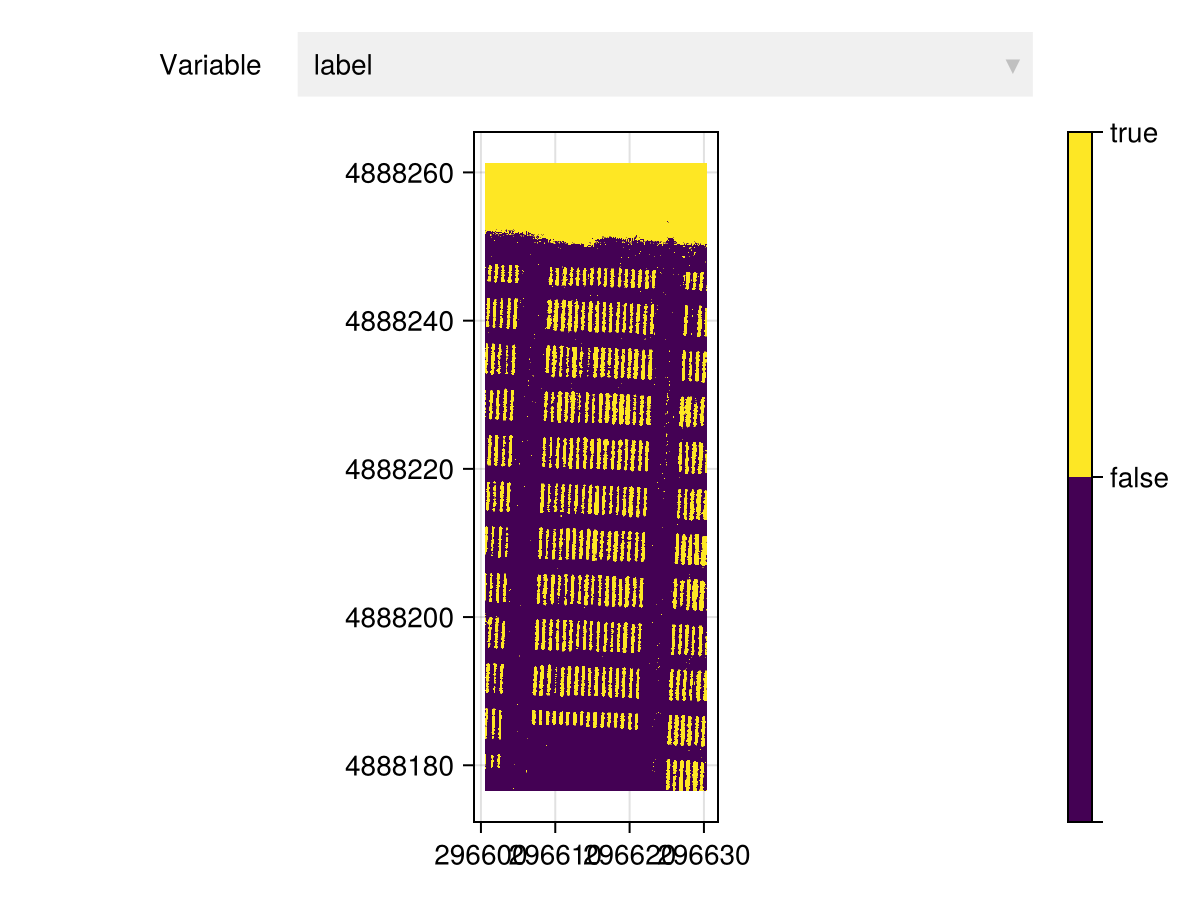

In [8]:
# Define a threshold by calculating the 70th percentile of the Hue values.
q70 = quantile(img_hue.HUE, 0.7)

# Define a function that returns `true` if a pixel's value is above the threshold.
# This will be used to identify vegetation.
isinside(x) = x > q70

# Apply the classification function to the "HUE" column.
# This creates a new GeoTable with a binary "label" column (`true` for vegetation).
binary = img_hue |> Map("HUE" => isinside => "label")

# Display the resulting binary mask in the interactive viewer.
binary |> viewer

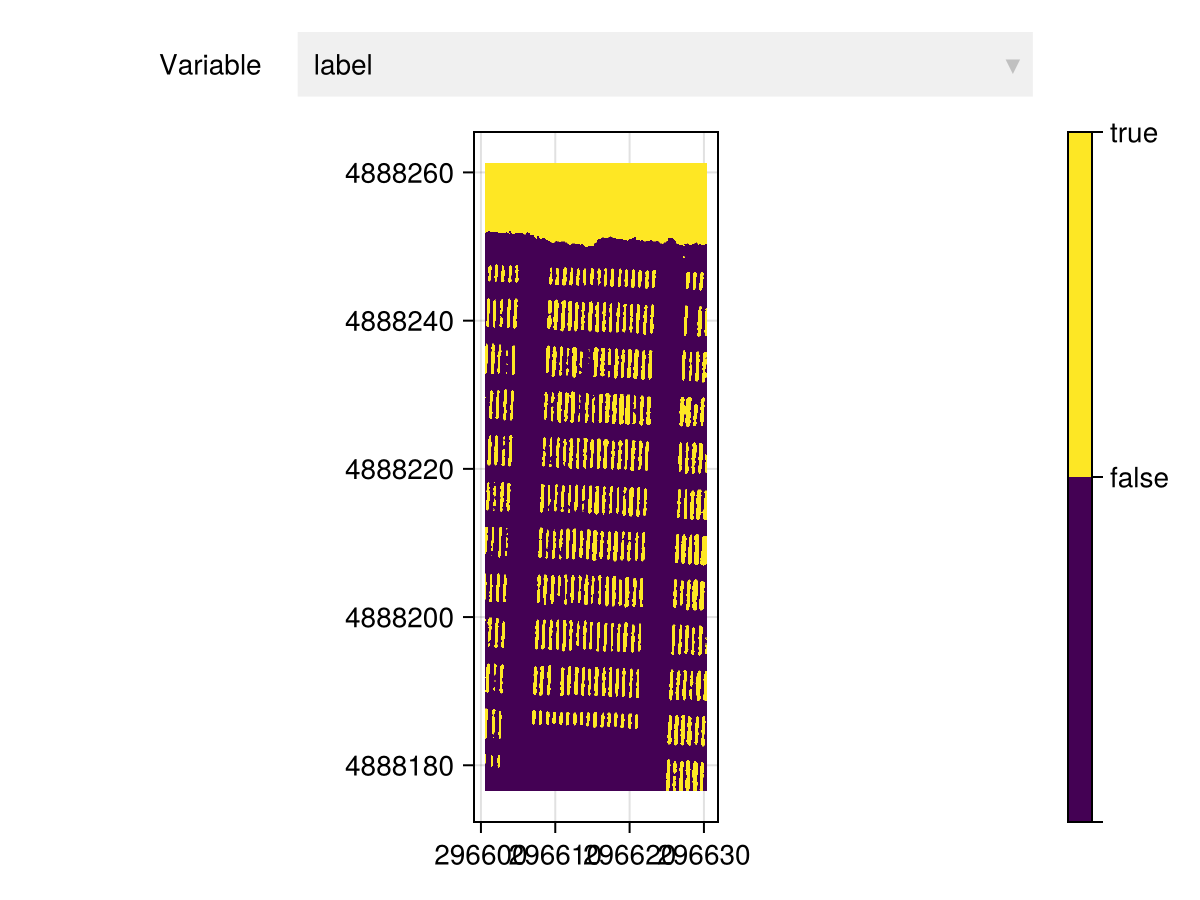

In [9]:
# Apply a Mode filter to smooth the binary mask.
# This removes small, isolated pixels (salt-and-pepper noise).
mask = binary |> ModeFilter()

# Display the cleaned-up mask in the viewer.
mask |> viewer

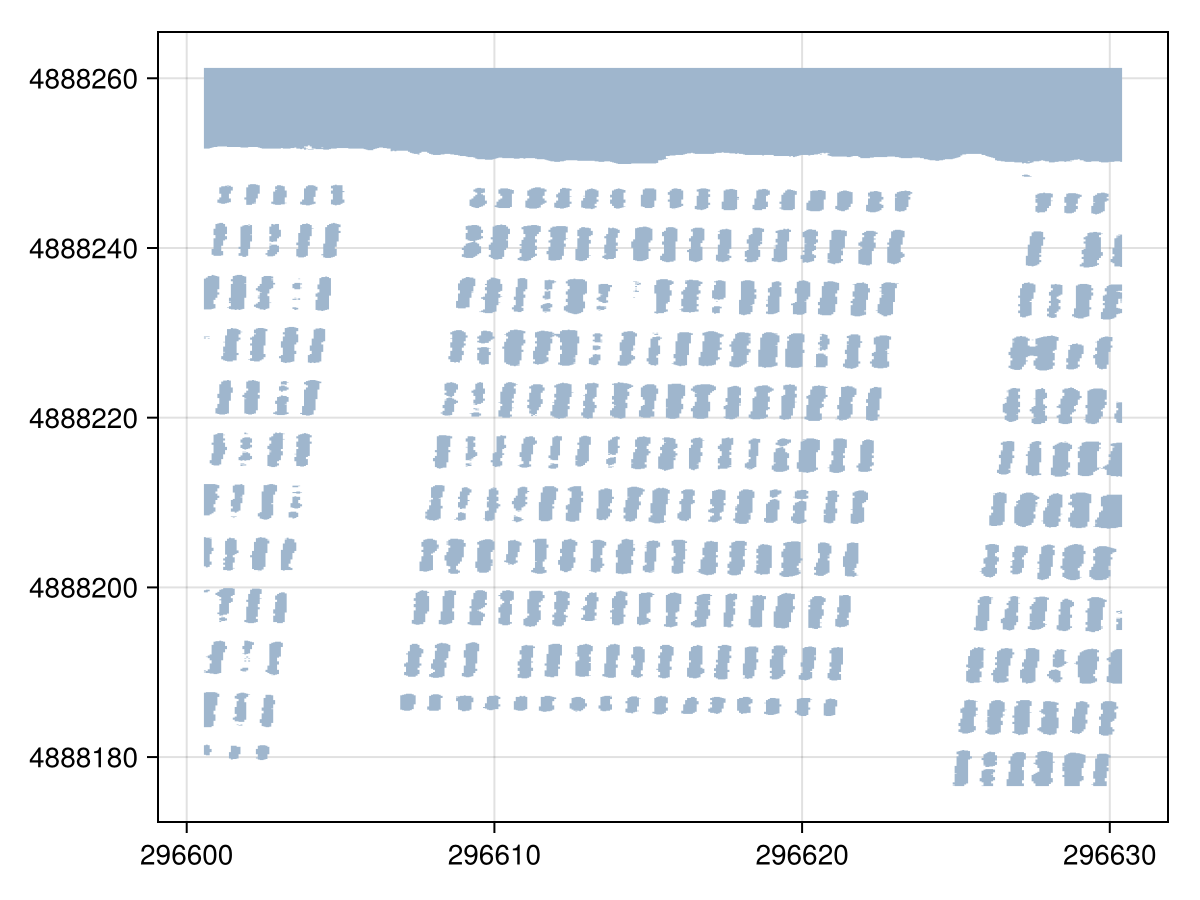

In [10]:
# Use the Potrace algorithm to convert the raster mask into vector polygons.
potrace = mask |> Potrace("label")

# Find the first polygon extracted by the algorithm.
region = potrace.geometry[findfirst(potrace.label)]

# Visualize the single extracted polygon.
region |> viz

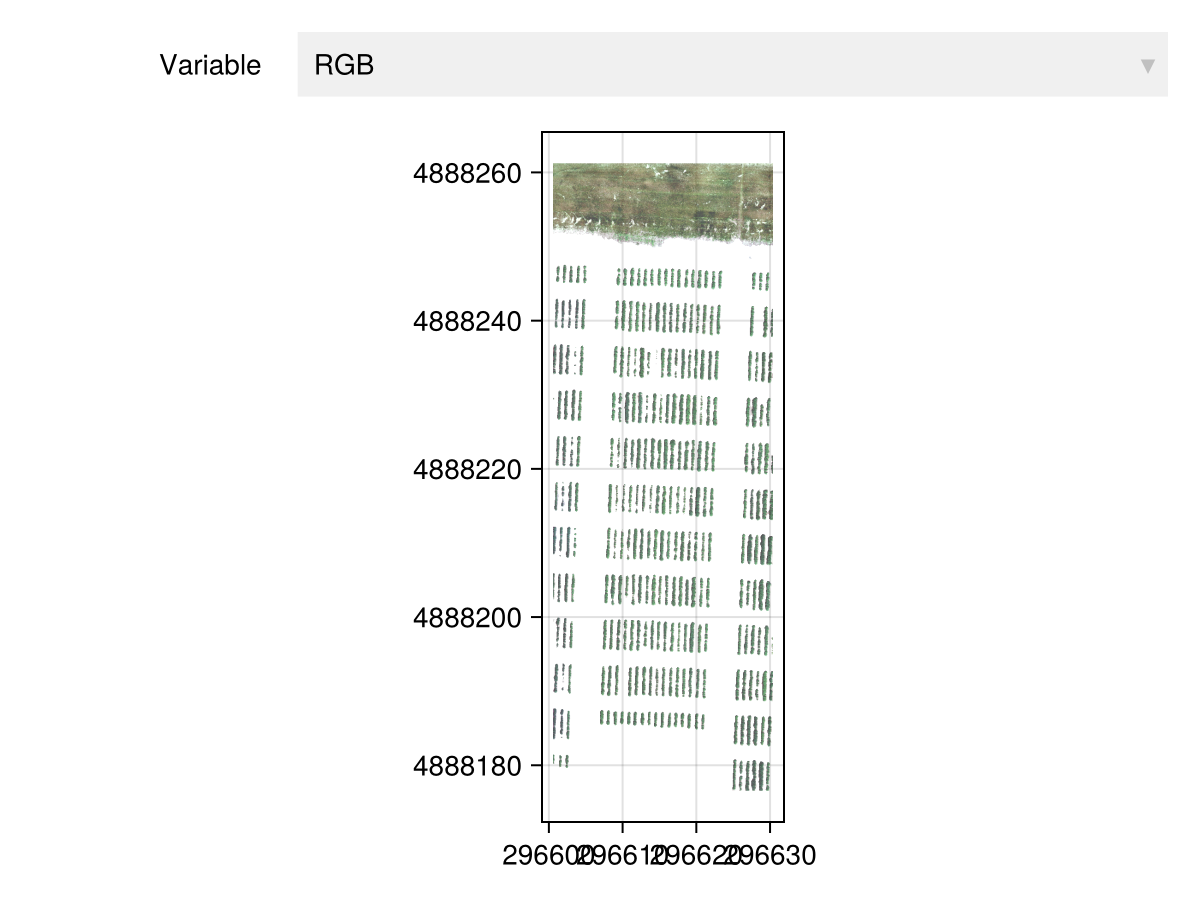

In [14]:
# Find all indices of the pixels that are `true` inside the mask.
inds = findall(mask.label);

# Use these indices to select only the pixels from the original `color` image.
# The result is a new GeoTable containing only the pixels within the mask.
masked_img = processed_image[inds,:];

# Display the resulting masked image in the viewer.
masked_img |> viewer

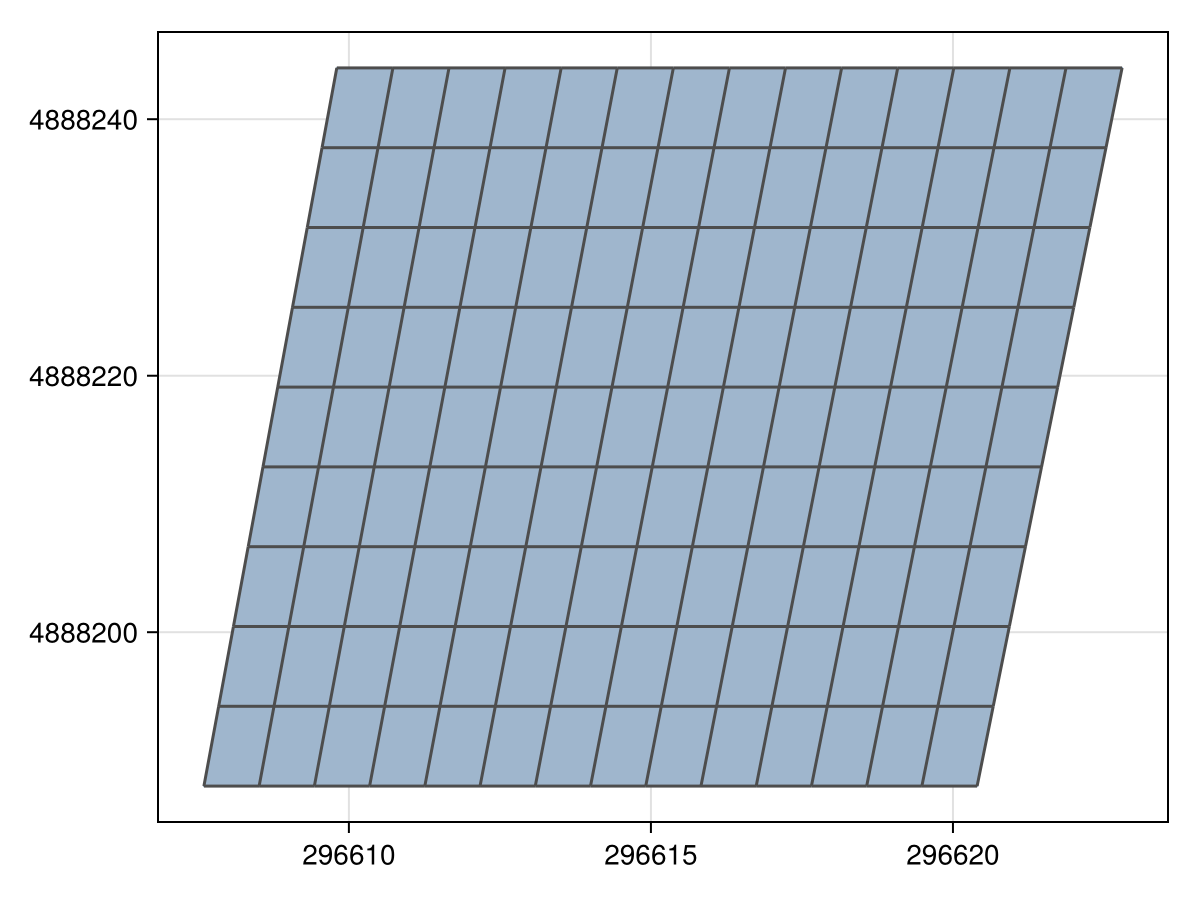

In [12]:
# Define the four corner points of a polygon.
p₁ = Point(296607.6, 4888188)
p₂ = Point(296620.4, 4888188)
p₃ = Point(296622.8, 4888244)
p₄ = Point(296609.8, 4888244)

# Create a Quadrangle geometry from the four points.
quad = Quadrangle(p₁, p₂, p₃, p₄)

# Discretize the quadrangle into a regular grid of 14x9 cells.
plotgrid = discretize(quad, RegularDiscretization(14, 9))

# Visualize the resulting grid, showing the segments of each cell.
viz(plotgrid, showsegments=true)

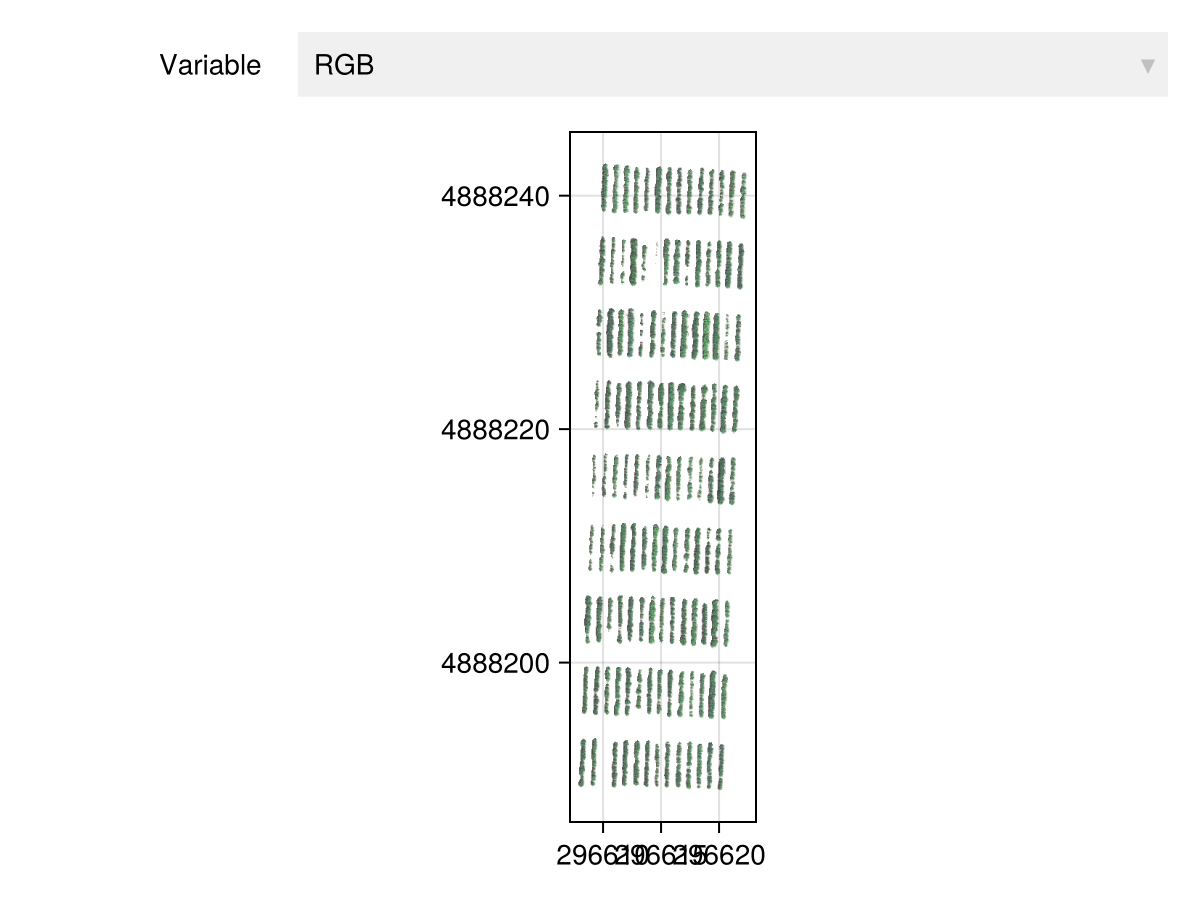

In [15]:
# Filtra a GeoTable criando uma "view" dos dados dentro da caixa
subset_view = masked_img[quad, :]
subset_view |> viewer

In [16]:
# Combine the tabular `data` with the `plotgrid` geometry to create a GeoTable.
gridtable = georef(data, plotgrid)

                      126×10 GeoTable over 126 SimpleMesh
┌─────────────┬─────────────┬─────────────┬─────────────┬────────────┬──────────
│    Plot     │    Block    │     Row     │    Range    │   Weight   │   Heigh ⋯
│ Categorical │ Categorical │ Categorical │ Categorical │ Continuous │ Continu ⋯
│  [NoUnits]  │  [NoUnits]  │  [NoUnits]  │  [NoUnits]  │ [NoUnits]  │ [NoUnit ⋯
├─────────────┼─────────────┼─────────────┼─────────────┼────────────┼──────────
│      1      │      1      │      1      │      1      │    4.25    │    21.0 ⋯
│      2      │      1      │      2      │      1      │    5.33    │    14.5 ⋯
│      3      │      1      │      3      │      1      │    3.76    │    37.5 ⋯
│      4      │      1      │      4      │      1      │    3.99    │    12.5 ⋯
│      5      │      1      │      5      │      1      │    6.79    │    25.5 ⋯
│      6      │      1      │      6      │      1      │   3.985    │    19.5 ⋯
│      7      │      1      │      7      │      1      │    4.7     │    14.0 ⋯
│      8      │      1      │      8      │      1      │    5.42    │    17.5 ⋯
│      9      │      1      │      9      │      1      │   2.885    │    43.5 ⋯
│     10      │      1      │     10      │      1      │    5.86    │    27.5 ⋯
│      ⋮      │      ⋮      │      ⋮      │      ⋮      │     ⋮      │     ⋮   ⋱
└─────────────┴─────────────┴─────────────┴─────────────┴────────────┴──────────
                                                  5 columns and 116 rows omitted

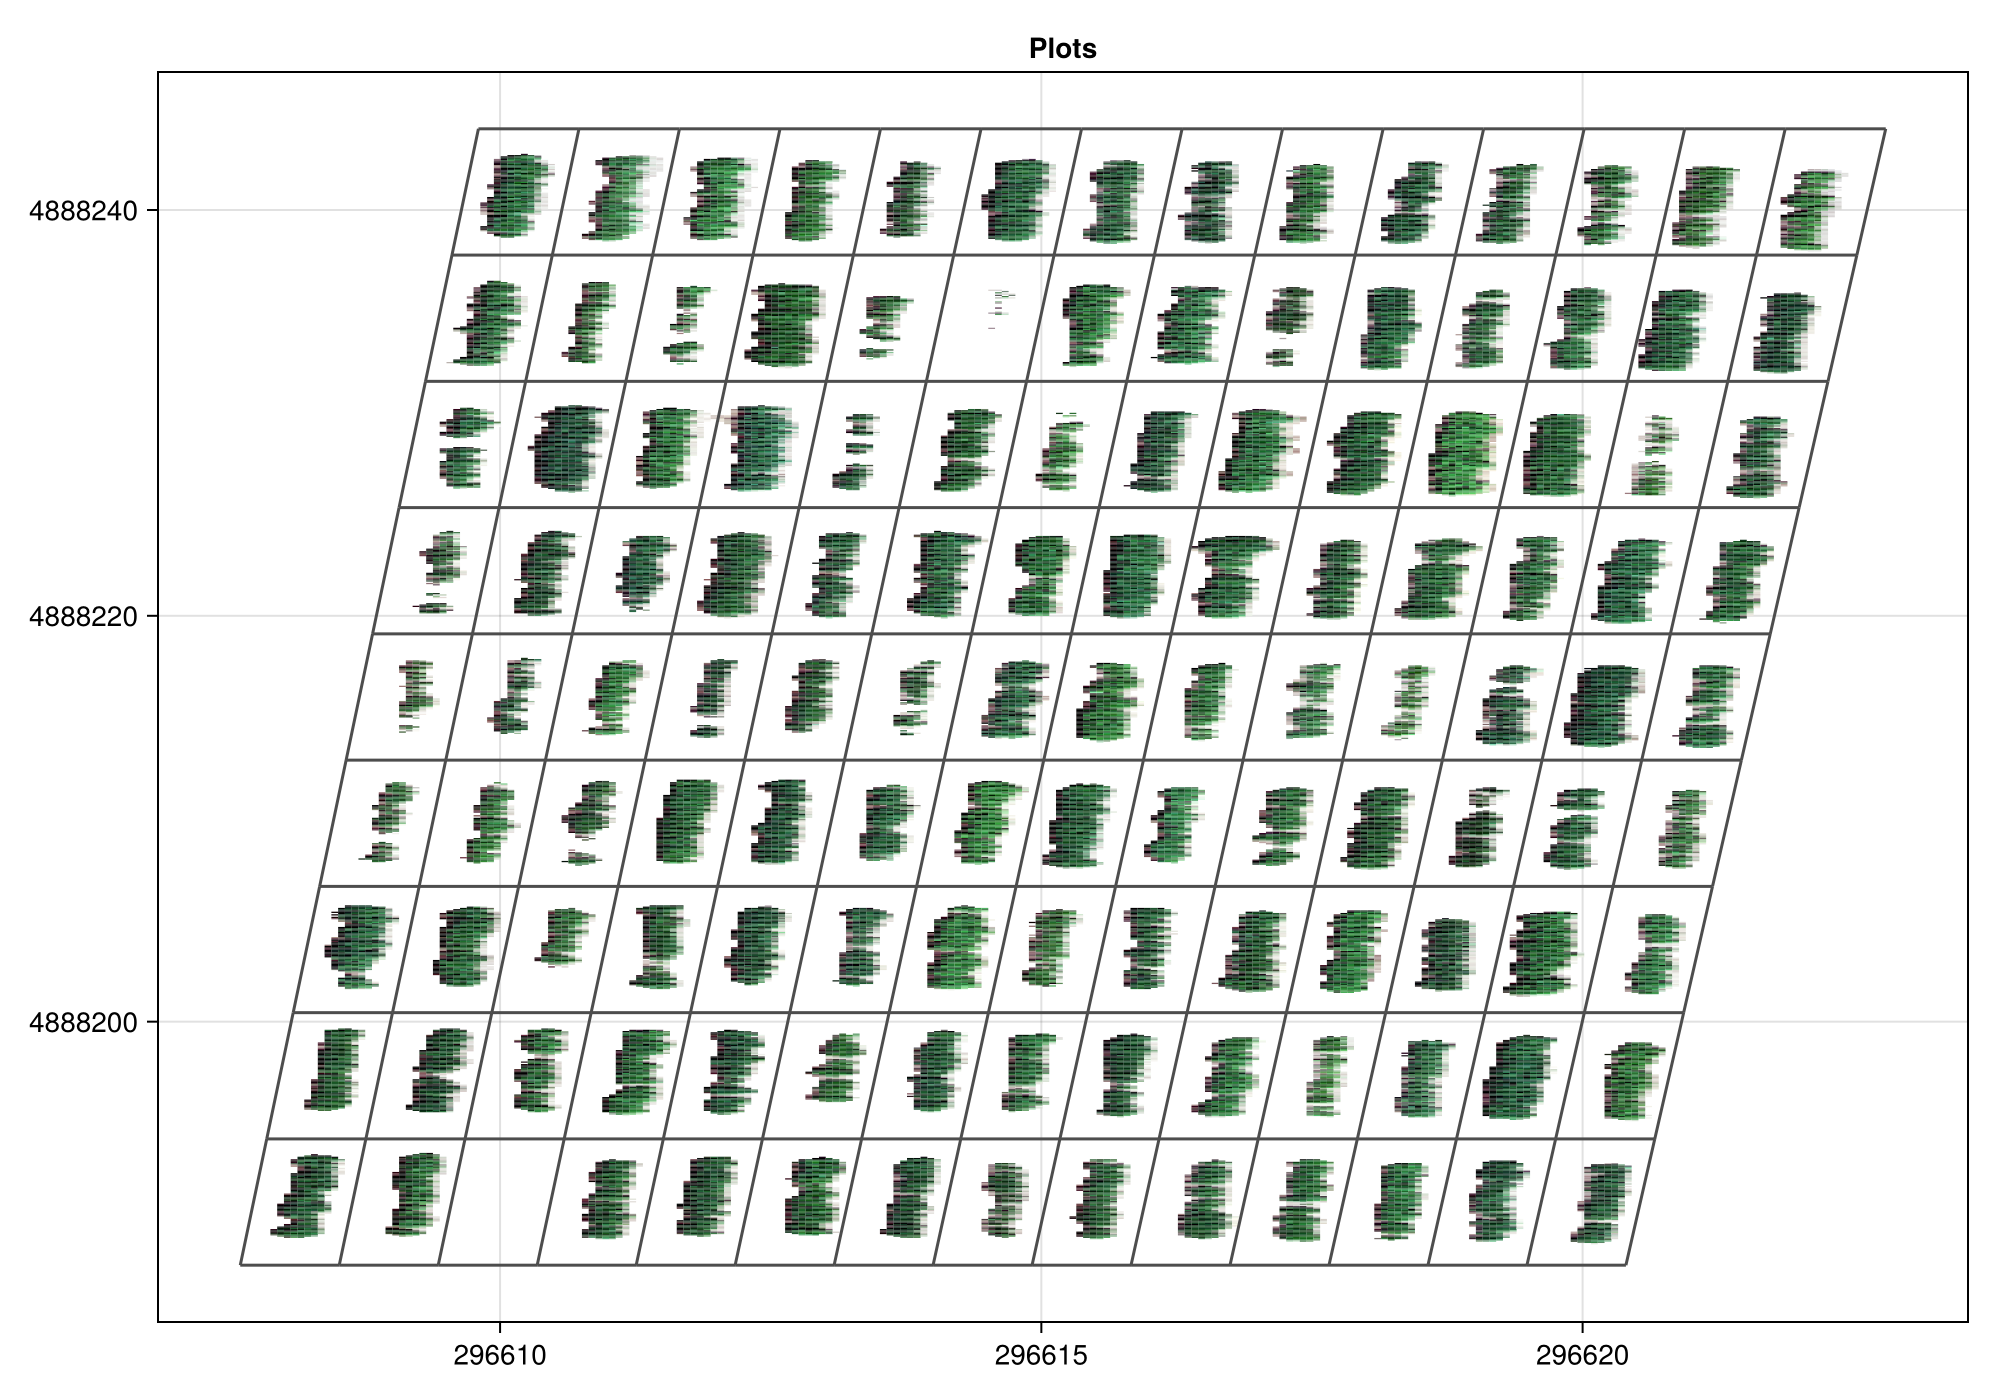

In [17]:
# Create a new Figure with a specified size.
fig = Mke.Figure(size = (1000, 700))

# --- Overlaid Axes ---
# Create two axes in the same grid position. The bottom one will hold the image,
# and the top one will hold the grid overlay.
ax_rgb  = Mke.Axis(fig[1, 1], title = "Plots")
ax_grid = Mke.Axis(fig[1, 1])

# Link the axes so that pan and zoom are synchronized between them.
Mke.linkaxes!(ax_rgb, ax_grid)

# Make the top axis transparent so we can see the bottom axis through it.
Mke.hidespines!(ax_grid)
Mke.hidedecorations!(ax_grid)
ax_grid.backgroundcolor = :transparent

# --- Plots ---
# Plot the grid geometry onto the top (transparent) axis.
viz!(ax_grid, plotgrid, alpha=0.0, showsegments = true)
# Plot the RGB image data onto the bottom axis.
viz!(ax_rgb, subset_view.geometry, color = subset_view.RGB)

# Display the final figure with both layers.
fig


In [ ]:
# NOTE: This interactive example with UI controls requires the GLMakie backend.
# The `Mke` alias should be set as `import GLMakie as Mke`.
Pkg.add("Observables")
using Observables

begin
  # --- Figure ---
  # Create a new Figure with a specified size.
  fig = Mke.Figure(size = (1000, 700))

  # --- Overlaid Axes ---
  # Create two axes in the same grid position.
  ax_rgb  = Mke.Axis(fig[1, 1], title = "Layer Viewer")
  ax_grid = Mke.Axis(fig[1, 1])

  # Link the axes to synchronize pan and zoom.
  Mke.linkaxes!(ax_rgb, ax_grid)

  # Make the top axis transparent so the bottom one is visible.
  Mke.hidespines!(ax_grid)
  Mke.hidedecorations!(ax_grid)
  ax_grid.backgroundcolor = :transparent

  # --- Plots ---
  # Plot the grid on the top axis.
  viz!(ax_grid, plotgrid, alpha=0.0, showsegments = true)
  # Plot the RGB image on the bottom axis.
  viz!(ax_rgb, subset_view.geometry, color = subset_view.RGB)

  # --- Controls ---
  # Create a layout grid for the UI controls below the plot.
  gl = Mke.GridLayout(fig[2, 1], tellwidth = false)

  # Add a toggle for the RGB layer visibility.
  Mke.Label(gl[1, 1], "Show RGB Layer")
  toggle_rgb = Mke.Toggle(gl[1, 2], active = true)

  # Add a toggle for the grid layer visibility.
  Mke.Label(gl[2, 1], "Show Grid Layer")
  toggle_grid = Mke.Toggle(gl[2, 2], active = true)

  # Add a toggle to control the aspect ratio.
  Mke.Label(gl[3, 1], "Fix Aspect Ratio")
  toggle_aspect = Mke.Toggle(gl[3, 2], active = false)

  # --- Callbacks ---
  # Create a callback to toggle the RGB axis visibility.
  on(toggle_rgb.active) do is_active
      ax_rgb.scene.visible[] = is_active
  end

  # Create a callback to toggle the grid axis visibility.
  on(toggle_grid.active) do is_active
      ax_grid.scene.visible[] = is_active
  end

  # Create a callback to switch the aspect ratio.
  on(toggle_aspect.active) do is_active
    if is_active
      # Lock the aspect ratio to the data's proportions.
      ax_rgb.aspect[] = DataAspect()
      ax_grid.aspect[] = DataAspect()
    else
      # Allow the aspect ratio to fill the available space.
      ax_rgb.aspect[] = nothing
      ax_grid.aspect[] = nothing
    end
  end

  # Display the final interactive figure.
  fig
end

In [ ]:
# Create a subset of the `rgb` GeoTable by selecting all pixels
# that fall within the bounds of the `quad` polygon.
subset_rgb_view = img[inds,:][quad, :]

51372×4 GeoTable over 51372 view(::TransformedGrid, [140870, 141345, 141346, 1 ⋯
┌────────────┬────────────┬────────────┬────────────────────────────────────────
│     R      │     G      │     B      │                                       ⋯
│ Continuous │ Continuous │ Continuous │                                     Q ⋯
│ [NoUnits]  │ [NoUnits]  │ [NoUnits]  │                          🖈 Transverse ⋯
├────────────┼────────────┼────────────┼────────────────────────────────────────
│  47.2461   │  47.2891   │  33.3398   │  Quadrangle((x: 2.9661e5 m, y: 4.8882 ⋯
│  23.5195   │  20.2617   │  15.1953   │  Quadrangle((x: 2.9661e5 m, y: 4.8882 ⋯
│  30.2812   │  47.1914   │  24.4492   │  Quadrangle((x: 2.9661e5 m, y: 4.8882 ⋯
│  39.9648   │  64.3008   │   32.832   │  Quadrangle((x: 2.9661e5 m, y: 4.8882 ⋯
│  46.2305   │  66.6367   │  37.0195   │  Quadrangle((x: 2.9661e5 m, y: 4.8882 ⋯
│  114.449   │  101.078   │  78.6992   │  Quadrangle((x: 2.9661e5 m, y: 4.8882 ⋯
│  102.227   │  92.0625   │  68.7969   │ Quadrangle((x: 2.96611e5 m, y: 4.8882 ⋯
│  116.191   │  104.086   │   80.168   │ Quadrangle((x: 2.96611e5 m, y: 4.8882 ⋯
│  129.691   │  111.285   │  88.0195   │ Quadrangle((x: 2.96611e5 m, y: 4.8882 ⋯
│  28.8008   │  36.8711   │  22.0977   │  Quadrangle((x: 296610.0 m, y: 4.8882 ⋯
│     ⋮      │     ⋮      │     ⋮      │                                       ⋱
└────────────┴────────────┴────────────┴────────────────────────────────────────
                                                 1 column and 51362 rows omitted

In [32]:
# Calculate the Normalized Green-Red Difference Index (NGRDI).
ngrdi = subset_rgb_view |> SpectralIndex("NGRDI")

# Calculate the Green Leaf Index (GLI).
gli = subset_rgb_view |> SpectralIndex("GLI")

# Calculate the Visible Atmospherically Resistant Index (VARI).
vari = subset_rgb_view |> SpectralIndex("VARI")

# Combine the three resulting GeoTables into a single table.
spec = [ngrdi gli vari]

51372×4 GeoTable over 51372 view(::TransformedGrid, [140870, 141345, 141346, 1 ⋯
┌─────────────┬────────────┬─────────────┬──────────────────────────────────────
│    NGRDI    │    GLI     │    VARI     │                                     ⋯
│ Continuous  │ Continuous │ Continuous  │                                     ⋯
│  [NoUnits]  │ [NoUnits]  │  [NoUnits]  │                          🖈 Transver ⋯
├─────────────┼────────────┼─────────────┼──────────────────────────────────────
│ 0.000454527 │ 0.0798805  │ 0.000702158 │  Quadrangle((x: 2.9661e5 m, y: 4.88 ⋯
│ -0.0744111  │ 0.0228247  │  -0.113966  │  Quadrangle((x: 2.9661e5 m, y: 4.88 ⋯
│  0.218273   │  0.265921  │  0.318919   │  Quadrangle((x: 2.9661e5 m, y: 4.88 ⋯
│  0.233403   │  0.277086  │  0.340679   │  Quadrangle((x: 2.9661e5 m, y: 4.88 ⋯
│  0.180799   │  0.23103   │  0.269043   │  Quadrangle((x: 2.9661e5 m, y: 4.88 ⋯
│  -0.062039  │  0.022787  │ -0.0977218  │  Quadrangle((x: 2.9661e5 m, y: 4.88 ⋯
│ -0.0523141  │ 0.0368904  │ -0.0809936  │ Quadrangle((x: 2.96611e5 m, y: 4.88 ⋯
│ -0.0549556  │ 0.0292005  │ -0.0864001  │ Quadrangle((x: 2.96611e5 m, y: 4.88 ⋯
│ -0.0763819  │  0.011037  │  -0.120336  │ Quadrangle((x: 2.96611e5 m, y: 4.88 ⋯
│  0.122888   │  0.183277  │  0.185208   │  Quadrangle((x: 296610.0 m, y: 4.88 ⋯
│      ⋮      │     ⋮      │      ⋮      │                                     ⋱
└─────────────┴────────────┴─────────────┴──────────────────────────────────────
                                                 1 column and 51362 rows omitted

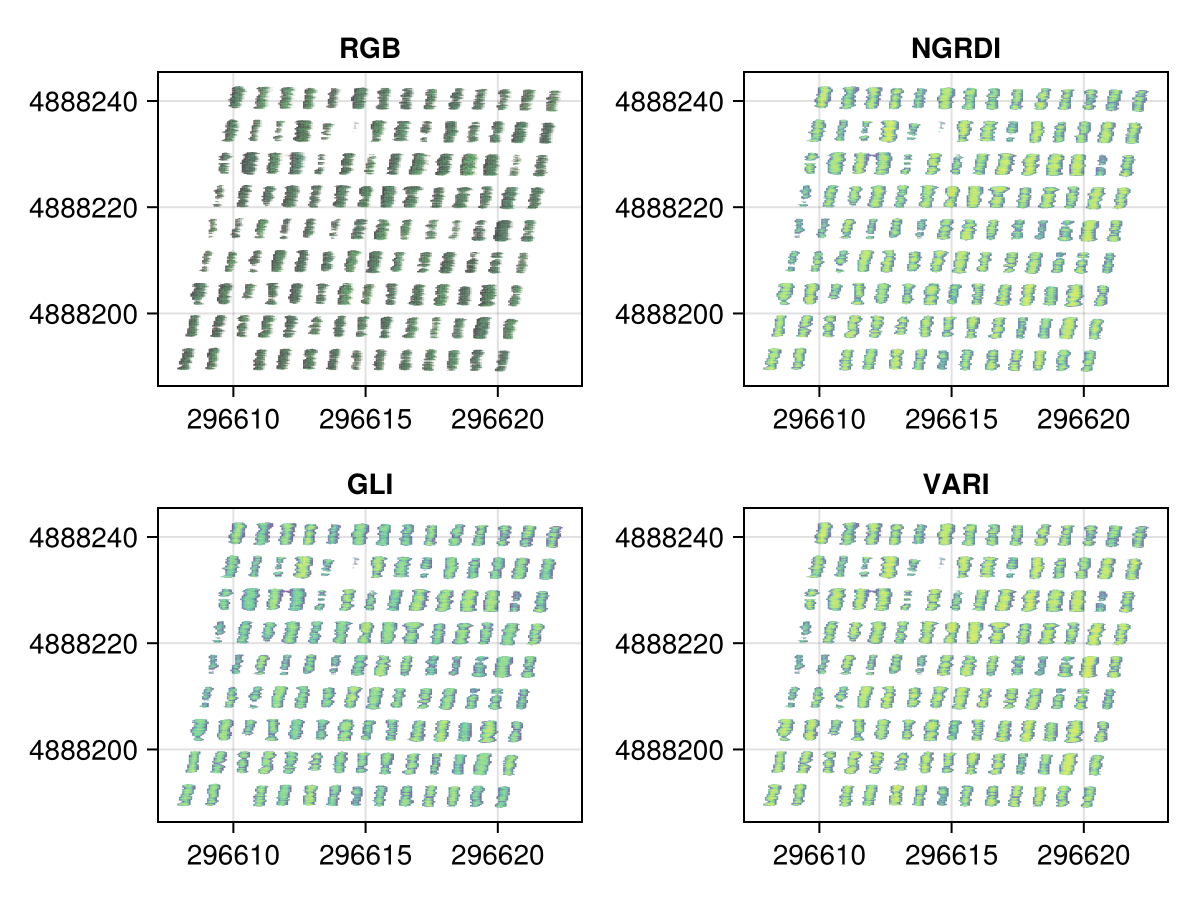

In [33]:
fig = Mke.Figure();
ax1 = Mke.Axis(fig[1, 1], title = "RGB")
ax2 = Mke.Axis(fig[1, 2], title = "NGRDI")
ax3 = Mke.Axis(fig[2, 1], title = "GLI")
ax4 = Mke.Axis(fig[2, 2], title = "VARI")
viz!(ax1, subset_view.geometry, color = subset_view.RGB)
viz!(ax2, spec.geometry, color = spec.NGRDI)
viz!(ax3, spec.geometry, color = spec.GLI)
viz!(ax4, spec.geometry, color = spec.VARI)
fig